# 1. Соберем окружение

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Dict, Any, NoReturn, Tuple
import numpy as np
import pandas as pd
import math
import os
import cv2
import xml
import decimal
import re
import itertools

from scipy.spatial import distance
from pathlib import Path
from tqdm import tqdm
import random

# Save model
import pickle
import dill
import joblib
import json

In [3]:
# Beziers
import sys
sys.path.insert(0, '..')
import beziers

from beziers.point import Point
from beziers.path import BezierPath
from beziers.cubicbezier import CubicBezier
from beziers.quadraticbezier import QuadraticBezier

In [4]:
%matplotlib inline
# %matplotlib notebook
# %matplotlib qt

import matplotlib as mpl
mpl.style.use('default')

# sns.set(rc={'figure.figsize':(10, 7)})
# sns.set_style("darkgrid", {'axes.grid':False})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', 100)

import warnings
warnings.simplefilter('ignore')

## 1.1 Определим пути

In [5]:
ROOT_DIRECTORY = ".."
GENERAL_DATA_DIRECTORY = Path(ROOT_DIRECTORY) / 'data'
BEZIERS_LIB_DIRECTORY = Path(ROOT_DIRECTORY) / 'beziers'

# 2. Задание
Научиться генерировать файлы стандартного формата, например SVG с описанием маршрутов на основе последовательностей кривых, которые выбираются из некоторого случайного множества. Описать параметры для распределений. Отображать последовательности точек вдоль этих маршрутов.

* **Форма:** Имеется один достаточно большой участок кривой, по которому можно оценивать параметры преобразования (гладкий без сложностей), и несколько более мелких, которые индуцируют реакции зрачков при слежении.
* **Количество:** 20-50 типов кривых, на каждом типе кривых несколько разных преобразований, например 10. И для каждого преобразования 100 разных реализаций разброса случайных точек вдоль пути, то получится как раз 20-50 тысяч.
* **Длина:** Нужно чтобы плавно движущаяся точка проходила кривую за 5 - 30 секунд и при этом не скакала из положения в положение, но и не слишком быстро. У нас есть 30 кадров в секунду - получается 150 - 900 кадров, каждый кадр - смещение на несколько пикселей (наверное не больше 5-10). Получается диапазон длин 1500 - 9000 пикселей. 

In [6]:
def generate_points_by_sectors(number: int, borders: Tuple[int, int], 
                           to_sort: bool, closed: bool) -> np.array:
    """
    Generates an array of placed points placed in sectors in the specified range.
    param: number - number of points to generate;
    param: borders - range for coordinate values;
    param: to_sort - sort array of points by both coordinates;
    param: closed - generate points so they form a closed Bezier path (end=start);
    return: float array shape [number x 2] with points coords [x, y];
    """ 
    points_arr = np.zeros((number, 2), dtype=np.float32)
    if (number < 4): 
        print("Number of points to generate should be more then {0}!".format(number))
        return points_arr
    middle = number // 2
    quarter = middle // 2    
    steps = (borders[0] / middle, borders[1] / quarter)
    temp_border_x = 0
    temp_border_y = 0
    # First part
    for i in range(middle):          
        points_arr[i, 0] = float(random.randint(temp_border_x, temp_border_x + steps[0]))
        points_arr[i, 1] = float(random.randint(temp_border_y, temp_border_y + steps[1]))
        temp_border_x += steps[0]
        if i == quarter: temp_border_y += steps[1]
    # Second part
    for i in range(middle, number):          
        points_arr[i, 0] = float(random.randint(temp_border_x - steps[0], temp_border_x))
        points_arr[i, 1] = float(random.randint(temp_border_y - steps[1], temp_border_y))
        temp_border_x -= steps[0]
        if i == quarter: temp_border_y -= steps[1]
    if to_sort:
        points_arr = sort_clockwise(points_arr)
    return points_arr

In [7]:
def generate_random_points(number: int, borders: Tuple[int, int], 
                           to_sort: bool, closed: bool) -> np.array:
    """
    Generates an array of randomly placed points in the specified range.
    param: number - number of points to generate;
    param: borders - range for coordinate values;
    param: to_sort - sort array of points by both coordinates;
    param: closed - generate points so they form a closed Bezier path (end=start);
    return: float array shape [number x 2] with points coords [x, y];
    """ 
    points_arr = np.zeros((number, 2), dtype=np.float32)
    for i in range(number):
        points_arr[i, 0] = float(random.randint(borders[0], borders[1]))
        points_arr[i, 1] = float(random.randint(borders[0], borders[1]))
        
    if to_sort:
        points_arr = sort_clockwise(points_arr)
    if closed:
        points_arr = np.vstack([points_arr, points_arr[0].reshape(1, 2) + np.full((1, 2), 0.000001)])
    
    return points_arr
    
def wrap_points(points_arr: np.array) -> List:
    """
    Wrap points array data into bezier.point.Point class;
    return: list of bezier.point.Point.
    """
    return [Point(p[0], p[1]) for p in points_arr]


def sort_clockwise(points: np.array):
    """
    Sorting according to clockwise points coordinates.
    """
    def centeroid(data: np.array):
        x, y = data[:, 0], data[:, 1]
        return sum(x)/len(x), sum(y)/len(y)
    
    centroid_x, centroid_y = centeroid(points)
    return np.array(sorted([tuple(p) for p in points], key = lambda x: 
                           math.atan2((x[1]-centroid_y),(x[0]-centroid_x)),reverse=True))

In [77]:
def plot_points(points_arr: np.ndarray, figsize: Tuple[float, float], 
                marker_size: float):
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(points_arr[:, 0], points_arr[:, 1], c='red', s=marker_size)
    ax.set_title('Случайно сгенерированные точки', fontsize=18)
#     for i in range(len(points_arr)):
#         ax.annotate(i, (points_arr[i, 0]-1.3, points_arr[i, 1]-1.3), fontsize=12)
    plt.show()

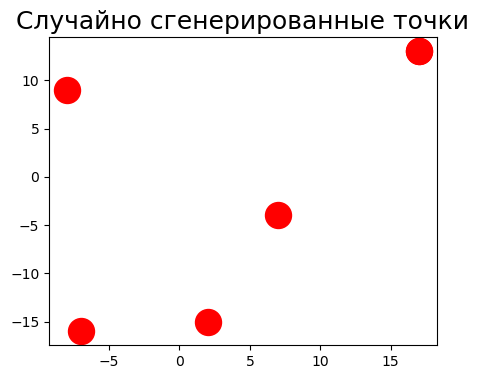

In [78]:
# sample_points = generate_random_points(5, (-20, 20), to_sort=False, closed=True)
plot_points(sample_points, figsize=(5, 4), marker_size=350)

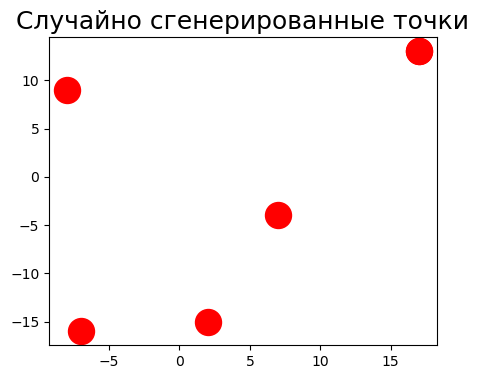

In [79]:
sample_points_s = sort_clockwise(sample_points)
plot_points(sample_points_s, figsize=(5, 4), marker_size=350)

In [8]:
def to_qubic_bezier(points):
    assert(len(points)==4, "For cubic beziers curve 4 points needed!")
    if isinstance(points[0], beziers.point.Point):
        return CubicBezier(points[0], points[1], points[2], points[3])
    else:
        return CubicBezier(Point(points[0, 0], points[0, 1]), Point(points[1, 0], points[1, 1]), 
                    Point(points[2, 0], points[2, 1]), Point(points[3, 0], points[3, 1])
)

def to_quadratic_bezier(points):
    assert(len(points)==3, "For quadratic beziers curve 3 points needed!")
    if isinstance(points[0], beziers.point.Point):
        return QuadraticBezier(points[0], points[1], points[2])
    else:
        return QuadraticBezier(Point(points[0, 0], points[0, 1]), Point(points[1, 0], points[1, 1]), 
                    Point(points[2, 0], points[2, 1]))
    
def make_bezier_curves(points, degrees: List[str]):
    """
    Create list of Bezier curves with different degrees from given points.
    """
    assert(sum(degrees) + len(degrees) == len(points), "Number of points should be suitable for given degrees list")
    curves = []
    ind = 0
    for degree in degrees:
        # Quadratic curve == 3 points
        if degree == 2:
            curves.append(to_quadratic_bezier([points[ind], points[ind+1], points[ind+2]]))
            ind += 3
        # Cubic curve == 4 points
        if degree == 3:
            curves.append(to_qubic_bezier([points[ind], points[ind+1], points[ind+2], points[ind+3]]))
            ind += 4
    return curves

In [56]:
def get_curve_as_points(curve: beziers.path.BezierPath, 
                        time_step=None, num_points=None) -> np.array:
                        
    """
    Creates array of points from curve equation with given step or number of points.
    return: numpy array shape [1, num_points*2] with x-y pairs of coordinates.
    """
    def drange(x, y, jump):
        while x < y:
            yield float(x)
            x += decimal.Decimal(jump)
        
    if time_step:
        points = [curve.pointAtTime(t) for t in drange(0, 1, time_step)]
        return np.array([[x, y] for (x, y) in zip([p.x for p in points], [p.y for p in points])], 
                        dtype=np.float32).reshape(1, -1)

    elif num_points:
        time_step = 1 / num_points
        points = [curve.pointAtTime(t) for t in drange(0, 1, time_step)]
        return np.array([[x, y] for (x, y) in zip([p.x for p in points], [p.y for p in points])], 
                        dtype=np.float32).reshape(1, -1)

    else:
        print("Error - should be specified time_step or num_points!")
        return np.zeros((1,1))

In [57]:
def generate_gaussian_noise(points_num: int, mu: float, sigma: float) -> np.array:
    """
    Generate random points sampled from a normal (Gaussian) distribution.
    return: numpy array shape [points_num, 2] with x-y pairs of coordinates.
    """
    return np.array([np.random.normal(mu, sigma, points_num),
                     np.random.normal(mu, sigma, points_num)], dtype=np.float32).reshape(1, -1)

In [58]:
def generate_outliers_rand(outliers_num: int, low: float, hight: float) -> np.array:
    """
    Generate outliers points.
    return: numpy array shape [outliers_num, 2] with x-y pairs of coordinates.
    """
    return np.array([np.random.randint(low, hight, outliers_num),
                     np.random.randint(low, hight, outliers_num)], dtype=np.float32).reshape(1, -1)

In [59]:
# Display images of a specific curve.
def display_curves(curves: List[beziers.path.BezierPath], curves_as_points: np.array,
                   generated_points: np.array,
                   n_cols: int, num_to_show=16, curve_figsize=(15, 30)) -> NoReturn:  
    """
    Show curves and plot points if they are given.
    """
    if len(curves) > 1:  # multiple curves
        num_to_show = min(len(curves), num_to_show)
        n_rows = int(np.ceil(num_to_show/n_cols))
        print("num_to_show", num_to_show)
        print("n_rows", n_rows)
        figsize = (curve_figsize[0], curve_figsize[1] * n_rows)
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, sharey=True)
        for i, curve in enumerate(curves):
            curve.plot(axs[i])
            if np.count_nonzero(curves_as_points)!= 0:
                axs[i].scatter(curves_as_points[i, :].reshape(-1, 2)[:, 0], curves_as_points[i, :].reshape(-1, 2)[:, 1], 
                               marker='o', c = 'deeppink')
            if np.count_nonzero(generated_points)!= 0:
                axs[i].scatter(generated_points[i, :].reshape(-1, 2)[:, 0], generated_points[i, :].reshape(-1, 2)[:, 1], 
                               marker='x', c = 'purple')
                
    elif (generated_points.shape[0] > 1) and (num_to_show > 1):  # single curve, but can be multiple points distributions
        n_rows = min(generated_points.shape[0], num_to_show)
        print("num_to_show", num_to_show)
        print("n_rows", n_rows)
        figsize = (curve_figsize[0], curve_figsize[1] * n_rows)
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, sharey=True)
        for i in range(n_rows):
            curves[0].plot(axs[i])
            if np.count_nonzero(curves_as_points)!= 0:
                axs[i].scatter(curves_as_points[i, :].reshape(-1, 2)[:, 0], curves_as_points[i, :].reshape(-1, 2)[:, 1], 
                                   marker='o', c = 'deeppink')
            if np.count_nonzero(generated_points)!= 0:
                axs[i].scatter(generated_points[i, :].reshape(-1, 2)[:, 0], generated_points[i, :].reshape(-1, 2)[:, 1], 
                               marker='x', c = 'purple')
    else:   # single curve, single points distribution
        n_rows=1
        figsize = (curve_figsize[0], curve_figsize[1] * n_rows)
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, sharey=True)
        curves[0].plot(axs)
        if np.count_nonzero(curves_as_points)!= 0:
            axs.scatter(curves_as_points[0].reshape(-1, 2)[:, 0], curves_as_points[0].reshape(-1, 2)[:, 1], 
                                   marker='o', c = 'deeppink')
        if np.count_nonzero(generated_points)!= 0:
            axs.scatter(generated_points[0].reshape(-1, 2)[:, 0], generated_points[0].reshape(-1, 2)[:, 1], 
                               marker='x', c = 'purple')
            
    plt.show()

In [60]:
def curves_to_svg(paths: List[beziers.path.BezierPath], 
                  dir_name: str, base_filename: str) -> NoReturn:
    """
    Save Bezier curves to SVG files.
    param: paths - Bezier paths list;
    param: dir_name - name of direction where to save files;
    param: base_filename - filename;
    return: -
    """
    def to_svg(path: beziers.path.BezierPath, filename: str) -> int:
        with open(filename + ".svg", 'w') as file:
            file.write('<?xml version="1.0" encoding="utf-8" standalone="no"?>\n')
            file.write('<svg version="1.1" width="460.8pt" height="345.6pt" viewBox="0 0 460.8 345.6"  xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">\n')
            file.write('<g stroke="black" fill="none" stroke-width="3">\n')
            file.write('<path d="')
            curves_to_write = ['C'+ c + '\n' for c in re.split(r'C', path.asSVGPath()) if c]
            file.writelines(curves_to_write)
            file.write('\nZ"\n' + '/>\n')
            file.write('</g>\n')
            file.write('</svg>\n')
    
    for i, path in enumerate(paths):
        filename = os.path.join(dir_name, "_".join(list(map(str, [base_filename, i]))))
        to_svg(path, filename)

In [71]:
# Create curves.
number_curves = 1
num_points = 100
curves = []
curve_num = 0
no_loops = True
curves_as_data = np.zeros((number_curves, num_points*2)) 

sample_points_1 = generate_random_points(12, (0, 20), to_sort=True, closed=True)

while len(curves) < number_curves:
    curve = BezierPath.fromPoints(wrap_points(sample_points_1), error=1.0, cornerTolerance=1.0, maxSegments=10)
    if (len(set([s.hasLoop for s in curve.asSegments()])) == 1) or not no_loops:
        curves.append(curve)
        
for curve in curves:
    curve.closed = True
    curve.balance()
        
# Create array of points from curve equation with given step or number of points.
for c_num, curve in enumerate(curves):
    curves_as_data[c_num, :] = get_curve_as_points(curve, time_step=None, num_points=num_points)

In [76]:
def plot_curve(curve, figsize: Tuple[float, float]):
    fig, ax = plt.subplots(figsize=figsize)
    curve.plot(ax)
    ax.set_title('Сгенерированные кривые Безье', fontsize=15)
    plt.show()

In [82]:
# plot_curve(curves[0], figsize=(15, 14))

# 3. Генерация датасета с одним типом кривой

In [15]:
def generate_curves(number_curves: int, points_per_curve: int,
                    borders: Tuple[int, int], no_loops: bool,
                    balanced: bool, num_dist_per_curve: int,
                    noise_power: float, mu: float, sigma: float,               
                    outliers_frac: float,
                    df_save_folder: str, df_filename: str,
                    svg_save_folder: str, svg_filename: str, 
                    to_save_svg: bool, to_save_df: bool,verbose: bool,
                    time_step=None, num_points=None) -> NoReturn:
    """
    Generates an array of curves with randomly placed points (knots) in the specified range.
    Generate three parts of the data independently: 
     - first non-outliers with noise, 
     - then lower- and upper outliers, 
     - merge them together, 
     - and finally shuffle them.
    Saves as SVG files and creates array of points on the curve for regression.
    Can be saved as DataFrame or numpy array.
    param: number_curves - number of curves to generate;
    param: points_per_curve - number of points in each curve;
    param: num_dist_per_curve - number of points distribution around each curve;
    param: borders - range for coordinate values;
    param: balanced - True if needed to perform Tunni balancing on the curve;
    param: no_loops - True if needed to make no loops in any segment of curve;
    param: noise_power, mu, sigma - parameters for gaussian distribution of noise;
    param: outliers_frac - fraction of outliers in curves data;
    param: df_save_folder and df_filename - for data DataFrame saving;
    param: svg_save_folder and svg_filename - for images in SVG format saving;
    param: to_save_svg - whether save images as SVG files;
    param: to_save_df - whether save data DataFrame;
    param: time_step - time step for representing curves as points;
    param: num_points - number of points for representing curves as points;
    param: verbose - print length, stats and et.
    return: -
    """ 
    # An array for (x,y) coord for each point on each curve
    # rows = t or point_num, columns = curve0_x, curve0_y, curve1_x, curve1_y ...
    if num_points:
        curves_as_data = np.zeros((number_curves, num_points*2)) 
        # An array for randomly generated points near each curve
        points_generated = np.zeros((number_curves*num_dist_per_curve, num_points*2)) 
    else:
        num_points = int(1 / time_step)
        curves_as_data = np.zeros((number_curves, num_points*2)) 
        # An array for randomly generated points near each curve
        points_generated = np.zeros((number_curves*num_dist_per_curve, num_points*2))
        
    # Create curves.
    curves = []
    curve_num = 0
    while len(curves) < number_curves:
        curve = BezierPath.fromPoints(wrap_points(generate_random_points(points_per_curve, borders, to_sort=True, closed=True)), 
                           error=10.0, cornerTolerance=10.0, maxSegments=50)
        if (len(set([s.hasLoop for s in curve.asSegments()])) == 1) or not no_loops:
            curves.append(curve)
        
    for curve in curves:
        curve.closed = True
        if balanced:
            curve.balance()
        
    # Create array of points from curve equation with given step or number of points.
    for c_num, curve in enumerate(curves):
#         TODO: BUGFIX! ValueError: could not broadcast input array from shape (286) into shape (284)
        curves_as_data[c_num, :] = get_curve_as_points(curve, time_step=time_step, num_points=num_points)
        
    # Create array of points generated with normal Gaussian noise across each curve.
    for c_num, curve in tqdm(enumerate(curves)):
        gen_per_curve = np.zeros((num_dist_per_curve, num_points*2))
        for c_dist in range(num_dist_per_curve):
            gen_per_curve[c_dist, :num_points * 2] = curves_as_data[c_num, :] + random.choices([1, -1], k=num_points * 2) * noise_power * generate_gaussian_noise(num_points, mu, sigma)
            # Outliers - replace some non-outlier with outliers 
            outliers = generate_outliers_rand(int(outliers_frac*num_points), borders[0], borders[1])  
            points_to_replace = sorted(np.random.choice(num_points, int(outliers_frac*num_points), replace=False))
            cols_to_replace = [coord for coords in [[point*2, point*2+1]  for point in points_to_replace] for coord in coords]
            gen_per_curve[c_dist, cols_to_replace] = outliers
            
        points_generated[c_num*num_dist_per_curve : (c_num + 1)*num_dist_per_curve, :] = gen_per_curve
        
    g_curve_ids = np.array([num for c_nums_list in [[c_num]*num_dist_per_curve for c_num, _ in enumerate(curves)] 
                          for num in c_nums_list]).reshape(1, -1).transpose()
    points_generated = np.hstack([g_curve_ids, points_generated])
        
    # Create DataFrames
    meta_columns = ['c_id', 'num_knots', 'as_svg', 'as_nodes', 'num_segments', 'curve_lenght',  'noise_mu', 'noise_sigma', 'num_outliers'] 
    gen_columns = ['c_id'] + [col for col_pair in  [[str(i) + '_x', str(i) + '_y'] 
                                                    for i in range(int(points_generated.shape[1]/2))] for col in col_pair]
    c_columns = [col for col_pair in  [[str(i) + 'c_x', str(i) + 'c_y'] 
                                                    for i in range(int(curves_as_data.shape[1]/2))] for col in col_pair]
    meta_data = [[c_num, points_per_curve, curve.asSVGPath(), curve.asNodelist(), len(curve.asSegments()), 
             curve.length, mu, sigma, int(outliers_frac*num_points)] for c_num, curve in enumerate(curves)]
    curves_meta_df = pd.DataFrame(meta_data, columns=meta_columns)
    curves_points_df = pd.DataFrame(curves_as_data, columns=c_columns)
    generated_points_df = pd.DataFrame(points_generated, columns=gen_columns)
    curves_df = curves_meta_df.join(curves_points_df)
    curves_df = curves_df.merge(generated_points_df, how='right', left_on='c_id', right_on='c_id')
    
    # Save dataframe
    if to_save_df:
        curves_df.to_csv(os.path.join(df_save_folder, df_filename), sep=';', header=True, encoding='utf-8-sig')
        
    # Save curves to svg
    if to_save_svg:
        try:
            curves_to_svg(curves, dir_name=svg_save_folder, base_filename=svg_filename)
        except IOError as e:
            print("I/O error({0}): {1}".format(e.errno, e.strerror))
        except ValueError:
            print("Could not convert data to type.")
        except:
            print("Unexpected error:", sys.exc_info()[0])
            raise
            
    if verbose:    
        for c_num, curve in enumerate(curves):
            print("Curve length: ", curves[c_num].length)
            print("Points generated around each cuve: ", points_generated.shape[1])
    return curves, curves_df

In [28]:
curves, curves_df = generate_curves(number_curves=1, points_per_curve=35,
                                    borders=(0, 700), num_dist_per_curve=10,
                                    balanced=True, no_loops=True, 
                                    noise_power=1, mu=17, sigma=1, outliers_frac=0.3,
                                    df_save_folder='results\\curves_0', df_filename='curves_0_df.csv',
                                    svg_save_folder='results\\curves_0', svg_filename='curve', 
                                    to_save_svg=False, to_save_df=False,
                                    num_points=300, verbose=False) 
print(curves_df.shape)
curves_df.head(10)

1it [00:00, 167.04it/s]


(10, 1209)


c_id  num_knots  \
0     0         35   
1     0         35   
2     0         35   
3     0         35   
4     0         35   
5     0         35   
6     0         35   
7     0         35   
8     0         35   
9     0         35   

                                                                                                as_svg  \
0  M 78.000000 426.000000 C 41.808013 540.104329 54.251017 611.468614 112.000000 621.000000  C 138....   
1  M 78.000000 426.000000 C 41.808013 540.104329 54.251017 611.468614 112.000000 621.000000  C 138....   
2  M 78.000000 426.000000 C 41.808013 540.104329 54.251017 611.468614 112.000000 621.000000  C 138....   
3  M 78.000000 426.000000 C 41.808013 540.104329 54.251017 611.468614 112.000000 621.000000  C 138....   
4  M 78.000000 426.000000 C 41.808013 540.104329 54.251017 611.468614 112.000000 621.000000  C 138....   
5  M 78.000000 426.000000 C 41.808013 540.104329 54.251017 611.468614 112.000000 621.000000  C 138....   
6  M 78.000000 426.000000 C 41.808013 540.104329 54.251017 611.468614 112.000000 621.000000  C 138....   
7  M 78.000000 426.000000 C 41.808013 540.104329 54.251017 611.468614 112.000000 621.000000  C 138....   
8  M 78.000000 426.000000 C 41.808013 540.104329 54.251017 611.468614 112.000000 621.000000  C 138....   
9  M 78.000000 426.000000 C 41.808013 540.104329 54.251017 611.468614 112.000000 621.000000  C 138....   

                                                                                              as_nodes  \
0  [<x=78.0 y=426.0 curve>, <x=41.80801335341885 y=540.1043287221461 offcurve>, <x=54.2510170204778...   
1  [<x=78.0 y=426.0 curve>, <x=41.80801335341885 y=540.1043287221461 offcurve>, <x=54.2510170204778...   
2  [<x=78.0 y=426.0 curve>, <x=41.80801335341885 y=540.1043287221461 offcurve>, <x=54.2510170204778...   
3  [<x=78.0 y=426.0 curve>, <x=41.80801335341885 y=540.1043287221461 offcurve>, <x=54.2510170204778...   
4  [<x=78.0 y=426.0 curve>, <x=41.80801335341885 y=540.1043287221461 offcurve>, <x=54.2510170204778...   
5  [<x=78.0 y=426.0 curve>, <x=41.80801335341885 y=540.1043287221461 offcurve>, <x=54.2510170204778...   
6  [<x=78.0 y=426.0 curve>, <x=41.80801335341885 y=540.1043287221461 offcurve>, <x=54.2510170204778...   
7  [<x=78.0 y=426.0 curve>, <x=41.80801335341885 y=540.1043287221461 offcurve>, <x=54.2510170204778...   
8  [<x=78.0 y=426.0 curve>, <x=41.80801335341885 y=540.1043287221461 offcurve>, <x=54.2510170204778...   
9  [<x=78.0 y=426.0 curve>, <x=41.80801335341885 y=540.1043287221461 offcurve>, <x=54.2510170204778...   

   num_segments  curve_lenght  noise_mu  noise_sigma  num_outliers  0c_x  \
0            28   4317.600261        17            1            90  78.0   
1            28   4317.600261        17            1            90  78.0   
2            28   4317.600261        17            1            90  78.0   
3            28   4317.600261        17            1            90  78.0   
4            28   4317.600261        17            1            90  78.0   
5            28   4317.600261        17            1            90  78.0   
6            28   4317.600261        17            1            90  78.0   
7            28   4317.600261        17            1            90  78.0   
8            28   4317.600261        17            1            90  78.0   
9            28   4317.600261        17            1            90  78.0   

    0c_y      1c_x        1c_y       2c_x        2c_y      3c_x        3c_y  \
0  426.0  69.40757  455.755676  63.164234  483.350647  59.25544  508.701447   
1  426.0  69.40757  455.755676  63.164234  483.350647  59.25544  508.701447   
2  426.0  69.40757  455.755676  63.164234  483.350647  59.25544  508.701447   
3  426.0  69.40757  455.755676  63.164234  483.350647  59.25544  508.701447   
4  426.0  69.40757  455.755676  63.164234  483.350647  59.25544  508.701447   
5  426.0  69.40757  455.755676  63.164234  483.350647  59.25544  508.701447   
6  426.0  69.40757  455.755676  63.1

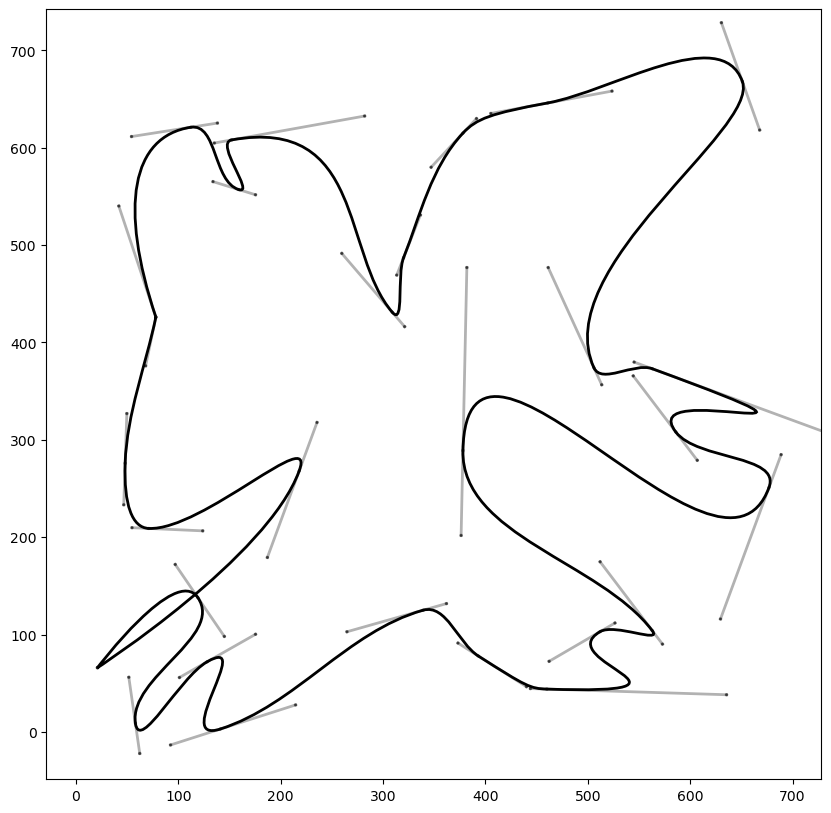

In [29]:
curve_to_show = 0
display_curves([curves[curve_to_show]], np.zeros((1,1)), generated_points=np.zeros((1,1)), 
               n_cols=1, curve_figsize=(10, 10))

num_to_show 16
n_rows 16


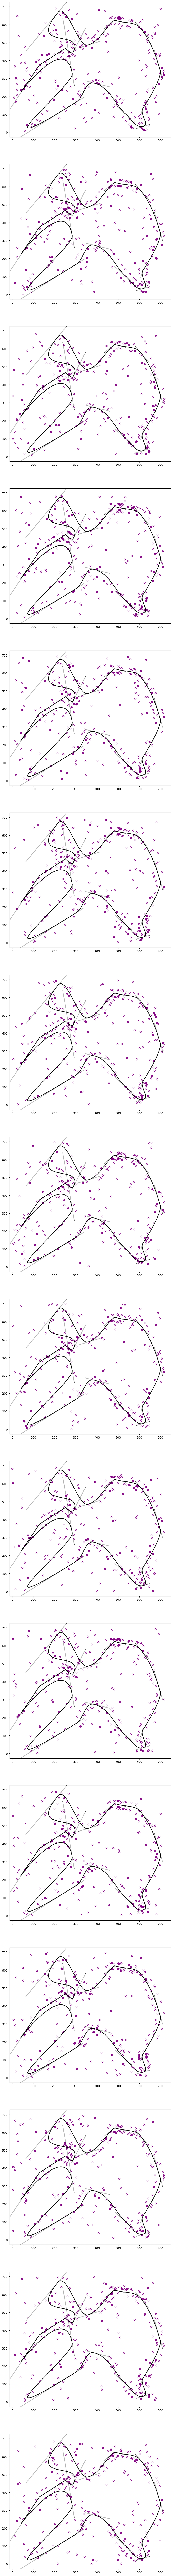

In [20]:
curve_to_show = 0
display_curves([curves[curve_to_show]], np.zeros((1,1)), generated_points=curves_df.loc[curves_df.c_id == curve_to_show].loc[:, '0_x':].values, 
               n_cols=1, curve_figsize=(10, 10))  #curves_as_data

# 3. Генерация датасета с разными типами кривых и параметрами шума

In [14]:
def save_info(info: Dict[str, Any], filename: str) -> NoReturn:
    """
    Saves information about parameters of dataset to the same folder.
    """
    with open(filename, "w") as write_file:
        json.dump(info, write_file, indent="")

In [15]:
def generate_curves_with_different_noise(number_curves: int, points_per_curve: int,
                    borders: Tuple[int, int], no_loops: bool, balanced: bool, num_dist_per_curve: int,
                    mu_list: List[float], sigma_list: List[float], outliers_frac_list: List[float],            
                    df_save_folder: str, df_filename: str,
                    svg_save_folder: str, svg_filename: str, 
                    to_save_svg: bool, to_save_df: bool, verbose: bool,
                    time_step=None, num_points=None) -> NoReturn:
    """
    Generates an array of curves with randomly placed points (knots) in the specified range.
    Generate three parts of the data independently: 
     - first non-outliers with noise, 
     - then lower- and upper outliers, 
     - merge them together, 
     - and finally shuffle them.
    Saves as SVG files and creates array of points on the curve for regression.
    Can be saved as DataFrame or numpy array.
    param: number_curves - number of curves to generate;
    param: points_per_curve - number of points in each curve;
    param: num_dist_per_curve - number of points distribution around each curve;
    param: borders - range for coordinate values;
    param: balanced - True if needed to perform Tunni balancing on the curve;
    param: no_loops - True if needed to make no loops in any segment of curve;
    param: mu_list, sigma_list - parameters for gaussian distribution of noise;
    param: outliers_frac_list - fraction of outliers in curves data;
    param: df_save_folder and df_filename - for data DataFrame saving;
    param: svg_save_folder and svg_filename - for images in SVG format saving;
    param: to_save_svg - whether save images as SVG files;
    param: to_save_df - whether save data DataFrame;
    param: time_step - time step for representing curves as points;
    param: num_points - number of points for representing curves as points;
    param: verbose - print length, stats and et.
    return: -
    """ 
    # Noise combinations of parameters
    noise_combinations = list(itertools.product(mu_list, sigma_list, outliers_frac_list))
    num_combinations = len(noise_combinations)
    
    # An array for (x,y) coord for each point on each curve
    # rows = t or point_num, columns = curve0_x, curve0_y, curve1_x, curve1_y ...
    if num_points:
        curves_as_data = np.zeros((number_curves, num_points*2)) 
        # An array for randomly generated points near each curve
        points_generated = np.zeros((num_combinations*number_curves*num_dist_per_curve, 
                                     num_points*2)) 
    else:
        num_points = int(1 / time_step)
        curves_as_data = np.zeros((number_curves, num_points*2)) 
        # An array for randomly generated points near each curve
        points_generated = np.zeros((num_combinations*number_curves*num_dist_per_curve,
                                     num_points*2))
        
    # Create curves.
    curves = []
    curve_num = 0
    while len(curves) < number_curves:
        curve = BezierPath.fromPoints(wrap_points(generate_random_points(points_per_curve, borders, to_sort=True, closed=True)), 
                           error=10.0, cornerTolerance=10.0, maxSegments=50)
        if (len(set([s.hasLoop for s in curve.asSegments()])) == 1) or not no_loops:
            curves.append(curve)
        
    for curve in curves:
        curve.closed = True
        if balanced:
            curve.balance()
        
    # Create array of points from curve equation with given step or number of points.
    for c_num, curve in enumerate(curves):
#         TODO: BUGFIX! ValueError: could not broadcast input array from shape (286) into shape (284)
        curves_as_data[c_num, :] = get_curve_as_points(curve, time_step=time_step, num_points=num_points)
        
    # Create array of points generated with normal Gaussian noise across each curve.
    for c_num, curve in tqdm(enumerate(curves)):
        gen_per_curve = np.zeros((num_combinations*num_dist_per_curve, num_points*2))                         
        for c_dist in range(num_dist_per_curve):
            for i, (mu, sigma, outliers_frac) in enumerate(noise_combinations):
                gen_per_curve[num_combinations*c_dist+i, :] = curves_as_data[c_num, :] + random.choices([1, -1], k=num_points * 2) * generate_gaussian_noise(num_points, mu, sigma)
                # Outliers - replace some non-outlier with outliers 
                outliers = generate_outliers_rand(int(outliers_frac*num_points), borders[0], borders[1])  
                points_to_replace = sorted(np.random.choice(num_points, int(outliers_frac*num_points), replace=False))
                cols_to_replace = [coord for coords in [[point*2, point*2+1]  for point in points_to_replace] 
                                   for coord in coords]
                gen_per_curve[num_combinations*c_dist+i, cols_to_replace] = outliers
            
        points_generated[c_num*num_dist_per_curve*num_combinations : 
                         (c_num + 1)*num_dist_per_curve*num_combinations, :] = gen_per_curve
        
    g_curve_ids = np.array([num for c_nums_list in [[c_num]*num_dist_per_curve*num_combinations
                                                    for c_num, _ in enumerate(curves)] 
                            for num in c_nums_list]).reshape(1, -1).transpose()

    g_noise_params = np.array([[[mu, sigma, outliers_frac] 
                                for (mu, sigma, outliers_frac) in noise_combinations]*num_dist_per_curve
                      for c_num, _ in enumerate(curves)]).reshape(-1, 3)
    
    g_points_with_params = np.hstack([g_curve_ids, g_noise_params, points_generated])

        
    # Create DataFrames
    meta_columns = ['c_id', 'num_knots', 'as_svg', 'as_nodes', 'num_segments', 'curve_lenght'] 
    gen_columns = ['c_id', 'noise_mu', 'noise_sigma', 'outliers_frac'] + [col for col_pair in  [[str(i) + '_x', str(i) + '_y'] 
                                                    for i in range(int(points_generated.shape[1]/2))] for col in col_pair]
    c_columns = [col for col_pair in  [[str(i) + 'c_x', str(i) + 'c_y'] 
                                                    for i in range(int(curves_as_data.shape[1]/2))] for col in col_pair]
    meta_data = [[c_num, points_per_curve, curve.asSVGPath(), curve.asNodelist(), len(curve.asSegments()), 
             curve.length] for c_num, curve in enumerate(curves)]
    
    curves_meta_df = pd.DataFrame(meta_data, columns=meta_columns)
    curves_points_df = pd.DataFrame(curves_as_data, columns=c_columns)
    generated_points_df = pd.DataFrame(g_points_with_params, columns=gen_columns)
    
    curves_df = curves_meta_df.join(curves_points_df)
    curves_df = curves_df.merge(generated_points_df, how='right', left_on='c_id', right_on='c_id')
    
    # Change columns order: metadata - first
    cols_to_order = ['c_id', 'num_knots', 'as_svg', 'as_nodes', 'num_segments', 
                   'curve_lenght', 'noise_mu', 'noise_sigma', 
                   'outliers_frac']
    new_columns = cols_to_order + (curves_df.columns.drop(cols_to_order).tolist())
    curves_df = curves_df[new_columns]
    
    # Save dataframe
    if to_save_df:
        curves_df.to_csv(os.path.join(df_save_folder, df_filename), sep=';', header=True, encoding='utf-8-sig')
        info_dict = {'num_curves': curves_df.c_id.nunique(), 'curves_lenghts': curves_df.curve_lenght.unique().tolist(), 
                     'num_knots': curves_df.num_knots.unique().tolist(), 'noise_mu': mu_list, 
                     'noise_sigma': sigma_list, 'outliers_frac': outliers_frac_list}
        save_info(info_dict,filename=os.path.join(df_save_folder, 'info.json'))
        
    # Save curves to svg
    if to_save_svg:
        try:
            curves_to_svg(curves, dir_name=svg_save_folder, base_filename=svg_filename)
        except IOError as e:
            print("I/O error({0}): {1}".format(e.errno, e.strerror))
        except ValueError:
            print("Could not convert data to type.")
        except:
            print("Unexpected error:", sys.exc_info()[0])
            raise
            
    if verbose:    
        for c_num, curve in enumerate(curves):
            print("Curve length: ", curves[c_num].length)
            print("Points generated around each cuve: ", points_generated.shape[1])
    return curves, curves_df

In [16]:
len(list(itertools.product([9, 13, 17, 21, 25, 29, 33], [1], [0.2, 0.3, 0.4, 0.5])))

28

In [18]:
curves, curves_df = generate_curves_with_different_noise(number_curves=10, points_per_curve=20,
                                    borders=(0, 700), num_dist_per_curve=200,
                                    balanced=False, no_loops=True, 
                                    mu_list=[9, 13, 17, 21, 25, 29, 33], sigma_list=[1], outliers_frac_list=[0.2, 0.3, 0.4, 0.5],
                                    df_save_folder='results\\curves_outliers_frac_estim_10', df_filename='curves_noise_estim_df.csv',
                                    svg_save_folder='results\\curves_outliers_frac_estim_10', svg_filename='curve', 
                                    to_save_svg=True, to_save_df=True,
                                    num_points=300, verbose=False) 
print(curves_df.shape)
curves_df.head(10)

10it [00:28,  2.84s/it]


(56000, 1209)


c_id  num_knots  \
0     0         20   
1     0         20   
2     0         20   
3     0         20   
4     0         20   
5     0         20   
6     0         20   
7     0         20   
8     0         20   
9     0         20   

                                                                                                as_svg  \
0  M 348.000000 292.000000 C 131.814056 383.523976 207.681545 302.268811 324.000000 455.000000  C 3...   
1  M 348.000000 292.000000 C 131.814056 383.523976 207.681545 302.268811 324.000000 455.000000  C 3...   
2  M 348.000000 292.000000 C 131.814056 383.523976 207.681545 302.268811 324.000000 455.000000  C 3...   
3  M 348.000000 292.000000 C 131.814056 383.523976 207.681545 302.268811 324.000000 455.000000  C 3...   
4  M 348.000000 292.000000 C 131.814056 383.523976 207.681545 302.268811 324.000000 455.000000  C 3...   
5  M 348.000000 292.000000 C 131.814056 383.523976 207.681545 302.268811 324.000000 455.000000  C 3...   
6  M 348.000000 292.000000 C 131.814056 383.523976 207.681545 302.268811 324.000000 455.000000  C 3...   
7  M 348.000000 292.000000 C 131.814056 383.523976 207.681545 302.268811 324.000000 455.000000  C 3...   
8  M 348.000000 292.000000 C 131.814056 383.523976 207.681545 302.268811 324.000000 455.000000  C 3...   
9  M 348.000000 292.000000 C 131.814056 383.523976 207.681545 302.268811 324.000000 455.000000  C 3...   

                                                                                              as_nodes  \
0  [<x=348.0 y=292.0 curve>, <x=131.8140555900599 y=383.523976465522 offcurve>, <x=207.681544759629...   
1  [<x=348.0 y=292.0 curve>, <x=131.8140555900599 y=383.523976465522 offcurve>, <x=207.681544759629...   
2  [<x=348.0 y=292.0 curve>, <x=131.8140555900599 y=383.523976465522 offcurve>, <x=207.681544759629...   
3  [<x=348.0 y=292.0 curve>, <x=131.8140555900599 y=383.523976465522 offcurve>, <x=207.681544759629...   
4  [<x=348.0 y=292.0 curve>, <x=131.8140555900599 y=383.523976465522 offcurve>, <x=207.681544759629...   
5  [<x=348.0 y=292.0 curve>, <x=131.8140555900599 y=383.523976465522 offcurve>, <x=207.681544759629...   
6  [<x=348.0 y=292.0 curve>, <x=131.8140555900599 y=383.523976465522 offcurve>, <x=207.681544759629...   
7  [<x=348.0 y=292.0 curve>, <x=131.8140555900599 y=383.523976465522 offcurve>, <x=207.681544759629...   
8  [<x=348.0 y=292.0 curve>, <x=131.8140555900599 y=383.523976465522 offcurve>, <x=207.681544759629...   
9  [<x=348.0 y=292.0 curve>, <x=131.8140555900599 y=383.523976465522 offcurve>, <x=207.681544759629...   

   num_segments  curve_lenght  noise_mu  noise_sigma  outliers_frac   0c_x  \
0            17   2744.515849       9.0          1.0            0.2  348.0   
1            17   2744.515849       9.0          1.0            0.3  348.0   
2            17   2744.515849       9.0          1.0            0.4  348.0   
3            17   2744.515849       9.0          1.0            0.5  348.0   
4            17   2744.515849      13.0          1.0            0.2  348.0   
5            17   2744.515849      13.0          1.0            0.3  348.0   
6            17   2744.515849      13.0          1.0            0.4  348.0   
7            17   2744.515849      13.0          1.0            0.5  348.0   
8            17   2744.515849      17.0          1.0            0.2  348.0   
9            17   2744.515849      17.0          1.0            0.3  348.0   

    0c_y        1c_x        1c_y        2c_x       2c_y        3c_x  \
0  292.0  315.864258  305.231171  288.483917  315.88382  265.629883   
1  292.0  315.864258  305.231171  288.483917  315.88382  265.629883   
2  292.0  315.864258  305.231171  288.483917  315.88382  265.629883   
3  292.0  315.864258  305.231171  288.483917  315.88382  265.629883   
4  292.0  315.864258  305.231171  288.483917  315.88382  265.629883   
5  292.0  315.864258  305.231171  288.483917  315.88382  265.629883   
6  292.0  315.864258  305.231171  288.483917  315.88382  265.629883   

In [19]:
curves_df.noise_mu.value_counts()

21.0    8000
13.0    8000
17.0    8000
29.0    8000
33.0    8000
25.0    8000
9.0     8000
Name: noise_mu, dtype: int64

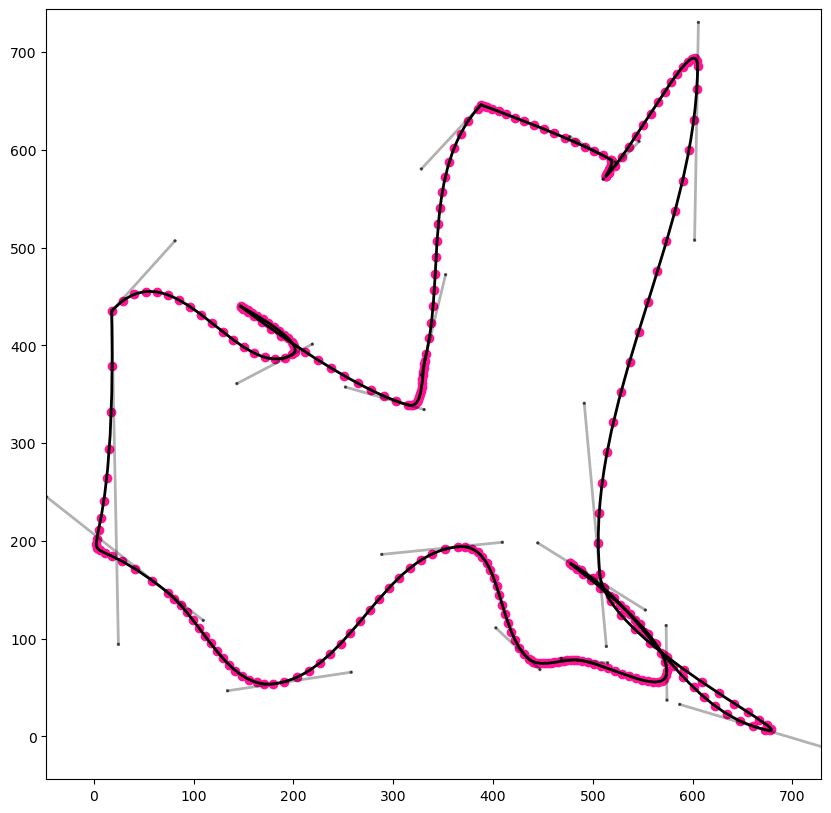

In [18]:
curve_to_show = 0
display_curves([curves[curve_to_show]], 
               curves_as_points=curves_df.loc[curves_df.c_id == curve_to_show].filter(regex=("[\d]+c_*")).values,
               generated_points= np.zeros((1,1)), 
               n_cols=1, curve_figsize=(10, 10), num_to_show=1)  #curves_as_data

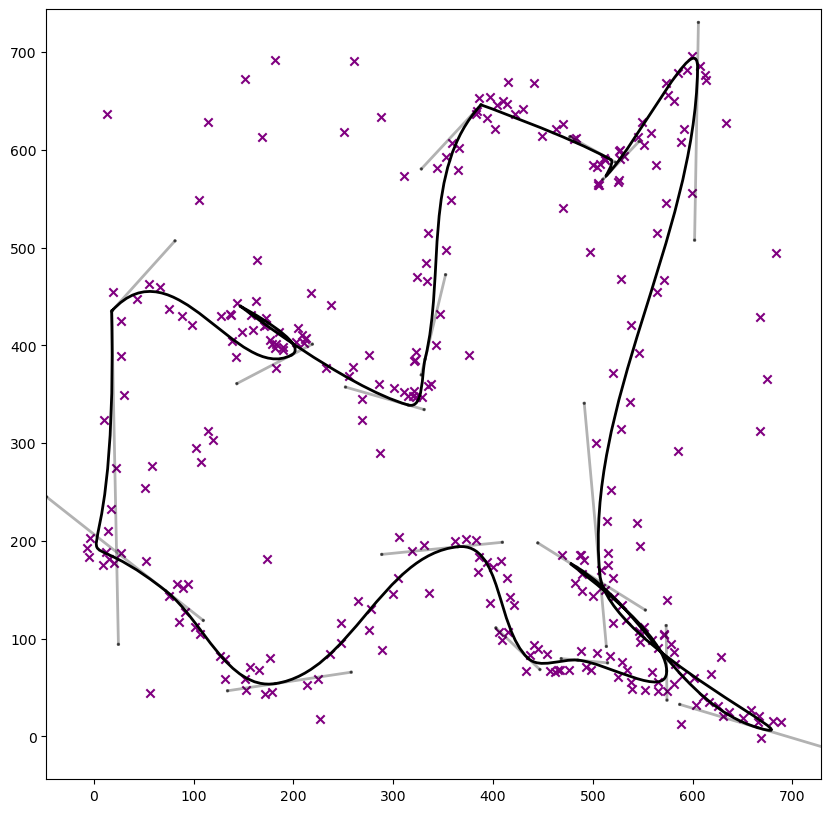

In [19]:
curve_to_show = 0
display_curves([curves[curve_to_show]], np.zeros((1,1)), generated_points=curves_df.loc[curves_df.c_id == curve_to_show].loc[:, '0_x':].values, 
               n_cols=1, curve_figsize=(10, 10), num_to_show=1)  #curves_as_data